# The Relationship between Home Square Footage and Voter Turnout in Historically Democratic vs Republican States.

$Abstract$:
 In this project we are interested in examining the question: is there a relationship between education, voter age, home square footage, and household income against voter turnout and further are there discrepencacies between the relationship when we compare against historically democratic and republican states? We expect to see that as age, education and income rise then voter turnout will demonstrate a positive linear relationship and also see a rise. We expect this relationship will be stronger in republican states when compared to democratic ones, as common knowledge suggests that older, wealthier indiviuals are more likely to vote than younger (potentially less wealthy) individuals.

# Data Loading

In [1]:
#First lets load in our data
from pyspark.sql.functions import input_file_name
from pyspark.sql.types import StructType
gcs_path = 'gs://pstat135-voter-file/VM2Uniform'
numrows = dict()

print("%s: " % ('VM2Uniform--FL--2021-05-19'), end="")
    
#Read dataframe for one_state
df1 = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--FL--2021-05-19'])).withColumn("State", input_file_name())
numrows['VM2Uniform--FL--2021-05-19'] = df1.count()
    
print("%d" % (numrows['VM2Uniform--FL--2021-05-19']))


VM2Uniform--FL--2021-05-19: 

14168189


In [2]:
print("%s: " % ('VM2Uniform--NY--2021-03-15'), end="")
    
#Read dataframe for one_state
df2 = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--NY--2021-03-15'])).withColumn("State", input_file_name())
numrows['VM2Uniform--NY--2021-03-15'] = df2.count()
    
print("%d" % (numrows['VM2Uniform--NY--2021-03-15']))

VM2Uniform--NY--2021-03-15: 

12570650


In [3]:
print("%s: " % ('VM2Uniform--TX--2021-06-12'), end="")
    
#Read dataframe for one_state
df3 = spark.read.parquet("/".join([gcs_path, 'VM2Uniform--TX--2021-06-12'])).withColumn("State", input_file_name())
numrows['VM2Uniform--TX--2021-06-12'] = df3.count()
    
print("%d" % (numrows['VM2Uniform--TX--2021-06-12']))

VM2Uniform--TX--2021-06-12: 

15983112


# Data Cleaning

In [4]:
#Select the column that we are interested in and subset the data
df1 =  df1.select(['Voters_Age', 'CommercialData_Education', 'CommercialData_EstimatedHHIncomeAmount', 'Residence_Addresses_Property_HomeSq_Footage', 'General_2020','State'])
df2 = df2.select(['Voters_Age', 'CommercialData_Education', 'CommercialData_EstimatedHHIncomeAmount', 'Residence_Addresses_Property_HomeSq_Footage', 'General_2020','State'])
df3 =  df3.select(['Voters_Age', 'CommercialData_Education', 'CommercialData_EstimatedHHIncomeAmount', 'Residence_Addresses_Property_HomeSq_Footage', 'General_2020','State'])

In [5]:
#Concatenate dataframe1 and dataframe2
df = df1.union(df2)

In [6]:
#Concatenate dataframe1, dataframe2 and dataframe3
df = df.union(df3)

In [7]:
#Delete the dollar sign of Income column and cast it to a double type.
import pyspark.sql.functions as f
df = df.withColumn('Income', f.regexp_replace('CommercialData_EstimatedHHIncomeAmount', '[$]', '').cast('double'))
df = df.drop('CommercialData_EstimatedHHIncomeAmount')

In [8]:
#Covert the voters turnout in to 1 and 0. 1 means the voter vote and o means the voter doesn't vote. 
from pyspark.sql.functions import when, col
df = df.withColumn("General_2020", when(col("General_2020").isNull(), 0).otherwise(when(col("General_2020") == "Y", 1).otherwise(col("General_2020"))))
df.show(10)

+----------+------------------------+-------------------------------------------+------------+--------------------+-------+
|Voters_Age|CommercialData_Education|Residence_Addresses_Property_HomeSq_Footage|General_2020|               State| Income|
+----------+------------------------+-------------------------------------------+------------+--------------------+-------+
|        63|                    null|                                       null|           1|gs://pstat135-vot...|77000.0|
|        33|    Some College - Li...|                                       null|           0|gs://pstat135-vot...|77000.0|
|        27|                    null|                                       null|           0|gs://pstat135-vot...|   null|
|        55|     HS Diploma - Likely|                                       null|           1|gs://pstat135-vot...|80000.0|
|        28|                    null|                                      01300|           1|gs://pstat135-vot...|65653.0|
|       

In [9]:
#Cast the data type of home square footage to integer. It used to be string.
df = df.withColumn('Home_Square_Footage', df['Residence_Addresses_Property_HomeSq_Footage'].cast('integer'))
df = df.drop('Residence_Addresses_Property_HomeSq_Footage')

In [10]:
#Change the file name to state label and make sure there are only three distinct values
from pyspark.sql.functions import substring
df = df.withColumn('State', substring('State', 49, 2))
df.select('State').distinct().count()

3

In [11]:
#Cast the voter turn out variable into boolean type
df = df.withColumn('General_2020', df['General_2020'].cast('boolean'))

In [12]:
#Cast the age column into integer type. It used to be string
df = df.withColumn('Voters_Age', df['Voters_age'].cast('integer'))

In [13]:
#Fill in all the numerical null values with the mean of that column
mean_value_age = df.agg({'Voters_Age': 'mean'}).collect()[0][0]
df = df.fillna(mean_value_age, subset=['Voters_Age'])

mean_value_income = df.agg({'Income': 'mean'}).collect()[0][0]
df = df.fillna(mean_value_income, subset=['Income'])

mean_value_footage = df.agg({'Home_Square_Footage': 'mean'}).collect()[0][0]
df = df.fillna(mean_value_footage, subset=['Home_Square_Footage'])

In [14]:
#There are two many null values in the Education column, we consider null as a possible value of that variable
df = df.fillna('Unknown', subset=['CommercialData_Education'])

In [15]:
#Creating age groups and square footage groups to help with EDA
df = df.withColumn("Age_Group", 
                                  when(df.Voters_Age.between(18, 24), '18-24')
                                  .when(df.Voters_Age.between(25, 34), '25-34')
                                  .when(df.Voters_Age.between(35, 44), '35-44')
                                  .when(df.Voters_Age.between(45, 54), '45-54')
                                  .when(df.Voters_Age.between(55, 64), '55-64')
                                  .when(df.Voters_Age.between(65, 150), '65+')
                                  .otherwise(None))
df = df.withColumn("HomeSq_Footage_Group", 
                                  when(df.Home_Square_Footage.between(0, 999), '0-999')
                                  .when(df.Home_Square_Footage.between(999, 1999), '1000-1999')
                                  .when(df.Home_Square_Footage.between(2000, 2999), '2000-2999')
                                  .when(df.Home_Square_Footage.between(3000, 4999), '3000-4999')
                                  .when(df.Home_Square_Footage.between(5000, 9999), '5000-9999')
                                  .when(df.Home_Square_Footage.between(10000, 999999), '10000+')
                                  .otherwise(None))

In [16]:
#Filter data set by state
from pyspark.sql.functions import col
df_fl = df.filter(col('State') == 'FL')
df_ny = df.filter(col('State') == 'NY')
df_tx = df.filter(col('State') == 'TX')

In [17]:
#Print dataframe to show that everything is working properly
df.show(5)
df.cache()

+----------+------------------------+------------+-----+-----------------+-------------------+---------+--------------------+
|Voters_Age|CommercialData_Education|General_2020|State|           Income|Home_Square_Footage|Age_Group|HomeSq_Footage_Group|
+----------+------------------------+------------+-----+-----------------+-------------------+---------+--------------------+
|        63|                 Unknown|        true|   FL|          77000.0|               2845|    55-64|           2000-2999|
|        33|    Some College - Li...|       false|   FL|          77000.0|               2845|    25-34|           2000-2999|
|        27|                 Unknown|       false|   FL|95789.53952917011|               2845|    25-34|           2000-2999|
|        55|     HS Diploma - Likely|        true|   FL|          80000.0|               2845|    55-64|           2000-2999|
|        28|                 Unknown|        true|   FL|          65653.0|               1300|    25-34|           100

DataFrame[Voters_Age: int, CommercialData_Education: string, General_2020: boolean, State: string, Income: double, Home_Square_Footage: int, Age_Group: string, HomeSq_Footage_Group: string]

First we want to select the columns that we are interested in, those being ['Voters_Age', 'CommercialData_Education', 'CommercialData_EstimatedHHIncomeAmount', 'Residence_Addresses_Property_HomeSq_Footage', 'General_2020','State'] . The initial data that we loaded in has saved each variable as a string, we want to cast these into the correct types (integers), as well as remove formatting that would affect analysis. In addition we want to cast our outcome variable into a Boolean value (1 representing that they voted and 0 indicating they did not vote in the 2020 election). We have a lot of null values, and so we decided removing all rows that contain null would be a waste of much of our data, instead we chose to fill the null values of our numerical values with their corresponding mean values; for categorical values we decided to let ‘null’ be handled as its own categorical value.

# Exploratory Data Analysis (EDA)

Due to the massive size of the original dataset, we randomly sampled 25% of it to help speed up the run time of our EDA.

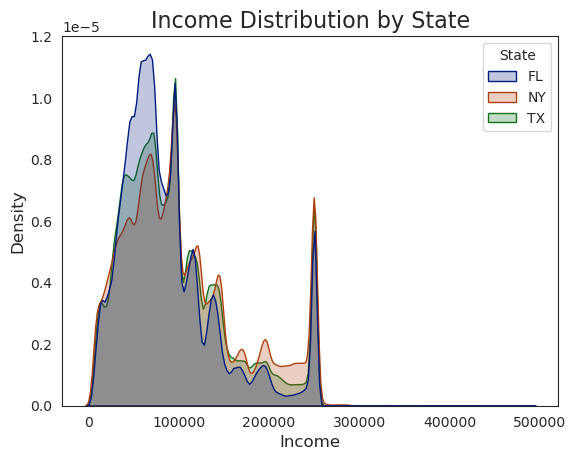

In [18]:
#Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Convert the PySpark DataFrame to a Pandas DataFrame
resampled_df = df.sample(withReplacement=False, fraction=0.25, seed=123)
pandas_df = resampled_df.toPandas()

#Create a KDE plot of the income distribution
sns.set_style("white")
sns.set_palette("dark")
sns.kdeplot(data=pandas_df, x='Income', hue='State', fill=True, common_norm=False)
plt.title('Income Distribution by State', fontsize=16)
plt.xlabel('Income', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

From the plot above, we can see that the income distribution for each state between 100,000 and 200,000 is very similar. Florida has a higher density below 100,000 while New York has a higher density above 200,000.

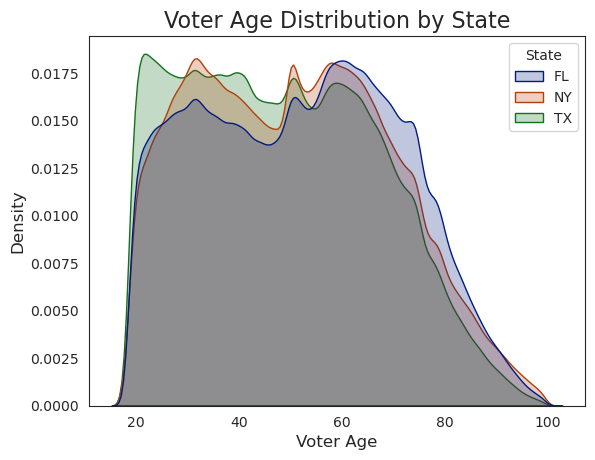

In [19]:
# create a KDE plot of the voter age distribution
sns.set_style("white")
sns.set_palette("dark")
sns.kdeplot(data=pandas_df, x='Voters_Age', hue='State', fill=True, common_norm=False)
plt.title('Voter Age Distribution by State', fontsize=16)
plt.xlabel('Voter Age', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

From the plot above, we can see that Texas has the youngest voter population of the three states while Florida has the oldest.

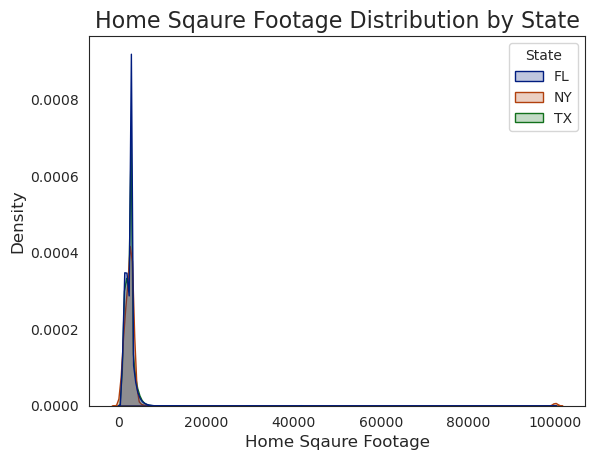

In [20]:
# create a KDE plot of the home square footage distribution
sns.set_style("white")
sns.set_palette("dark")
sns.kdeplot(data=pandas_df, x='Home_Square_Footage', hue='State', fill=True, common_norm=False)
plt.title('Home Sqaure Footage Distribution by State', fontsize=16)
plt.xlabel('Home Sqaure Footage', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.show()

The distribution of home sqaure footage is very similar across the three states.

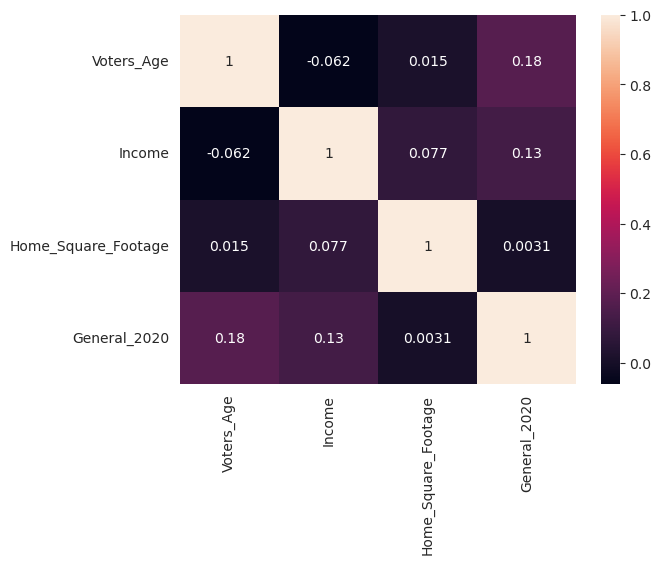

In [21]:
df1 = df.select(['Voters_Age', 'Income', 'Home_Square_Footage', 'General_2020'])
df2 = df1.sample(withReplacement=False, fraction=0.25, seed=123).toPandas()
df2 = df2.astype({'General_2020': 'int64'})

# Compute the correlation matrix
corr_matrix = df2.corr()

# Create a heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True)

# Show the plot
plt.show()

From the correlation heatmap above, we can see that every variable is very close to being uncorrelated. The greatest correlations are voter age vs. voter turnout and income vs. voter turnout. This bodes well for using the data to fit a logistic regression model since each predictor is relatively uncorrelated.

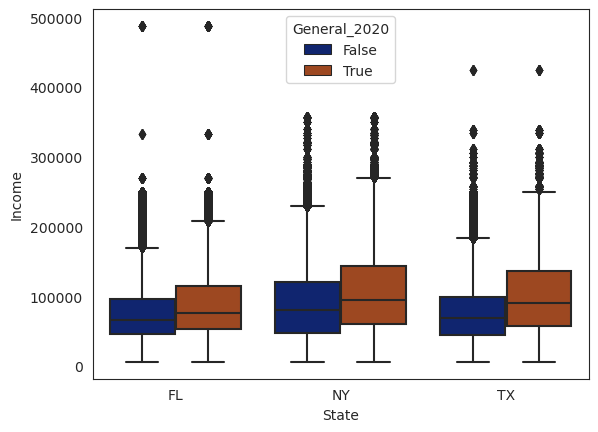

In [22]:
sns.boxplot(y='Income', 
            x= 'State', 
            hue='General_2020',
            data=pandas_df)
plt.show()

In the box plot above, we see that in each state, the average income of those who vote is greater than those who do not.

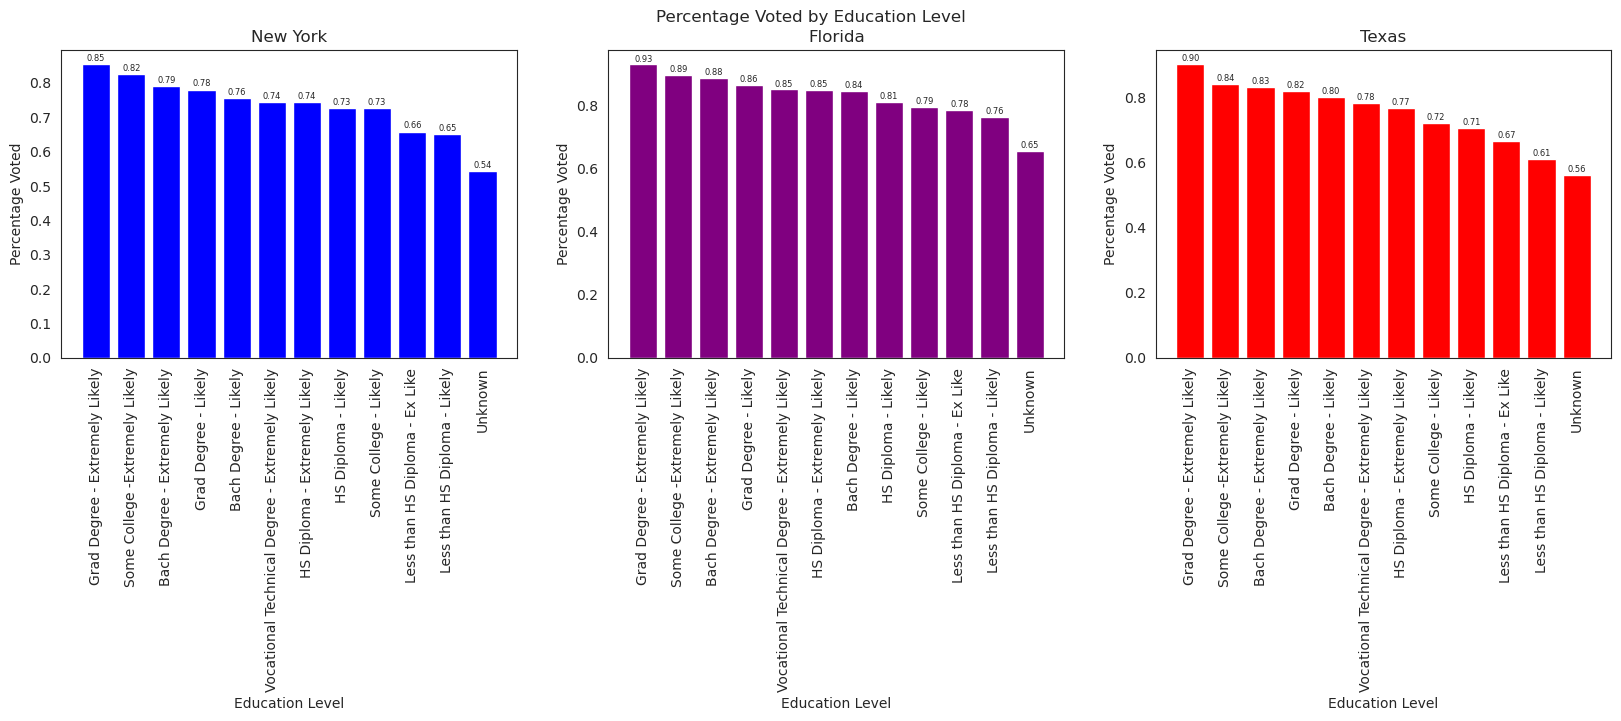

In [23]:
import matplotlib.pyplot as plt
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import count,col

fig, axs = plt.subplots(1, 3, figsize=(20,4))

NY_edu = df_ny.groupBy('CommercialData_Education').agg(count(when(col("General_2020")==True,True)).alias("Num_Voted"), count("General_2020").alias("Num_Total"))
NY_edu = NY_edu.withColumn("CommercialData_Education", when(col("CommercialData_Education").isNull(), "Unknown").otherwise(col("CommercialData_Education")))
NY_edu = NY_edu.withColumn('Percent_Voted',col("Num_Voted")/col("Num_Total"))
NY_edu = NY_edu.orderBy('Percent_Voted', ascending=False)
NYedu_pd = NY_edu.toPandas()

axs[0].bar(NYedu_pd.CommercialData_Education,NYedu_pd.Percent_Voted,color='blue')
axs[0].set_xlabel("Education Level")
axs[0].set_ylabel("Percentage Voted")
axs[0].set_title("New York")
for i, v in enumerate(NYedu_pd.Percent_Voted):
    axs[0].text(i, v+0.01, '{:.2f}'.format(v), ha='center', fontsize=6)
    
FL_edu = df_fl.groupBy('CommercialData_Education').agg(count(when(col("General_2020")==True,True)).alias("Num_Voted"), count("General_2020").alias("Num_Total"))
FL_edu = FL_edu.withColumn("CommercialData_Education", when(col("CommercialData_Education").isNull(), "Unknown").otherwise(col("CommercialData_Education")))
FL_edu = FL_edu.withColumn('Percent_Voted',col("Num_Voted")/col("Num_Total"))
FL_edu = FL_edu.orderBy('Percent_Voted', ascending=False)
FLedu_pd = FL_edu.toPandas()
    
axs[1].bar(FLedu_pd.CommercialData_Education,FLedu_pd.Percent_Voted,color='purple')
axs[1].set_xlabel("Education Level")
axs[1].set_ylabel("Percentage Voted")
axs[1].set_title("Florida")
for i, v in enumerate(FLedu_pd.Percent_Voted):
    axs[1].text(i, v+0.01, '{:.2f}'.format(v), ha='center', fontsize=6)

TX_edu = df_tx.groupBy('CommercialData_Education').agg(count(when(col("General_2020")==True,True)).alias("Num_Voted"), count("General_2020").alias("Num_Total"))
TX_edu = TX_edu.withColumn("CommercialData_Education", when(col("CommercialData_Education").isNull(), "Unknown").otherwise(col("CommercialData_Education")))
TX_edu = TX_edu.withColumn('Percent_Voted',col("Num_Voted")/col("Num_Total"))
TX_edu = TX_edu.orderBy('Percent_Voted', ascending=False)
TXedu_pd = TX_edu.toPandas()
    
axs[2].bar(TXedu_pd.CommercialData_Education,TXedu_pd.Percent_Voted,color='red')
axs[2].set_xlabel("Education Level")
axs[2].set_ylabel("Percentage Voted")
axs[2].set_title("Texas")
for i, v in enumerate(TXedu_pd.Percent_Voted):
    axs[2].text(i, v+0.01, '{:.2f}'.format(v), ha='center', fontsize=6)

fig.suptitle('Percentage Voted by Education Level')
for ax in axs:
    ax.tick_params(axis='x', labelrotation=90)
plt.show()

From the above plots, we can see that education level seems to impact whether someone voted or not. 'Grad Degree', 'Some College', and 'Bach Degree' top the charts in all three states while 'Less than HS Diploma' has the lowest percentage in all three states (excluding 'Unknown').

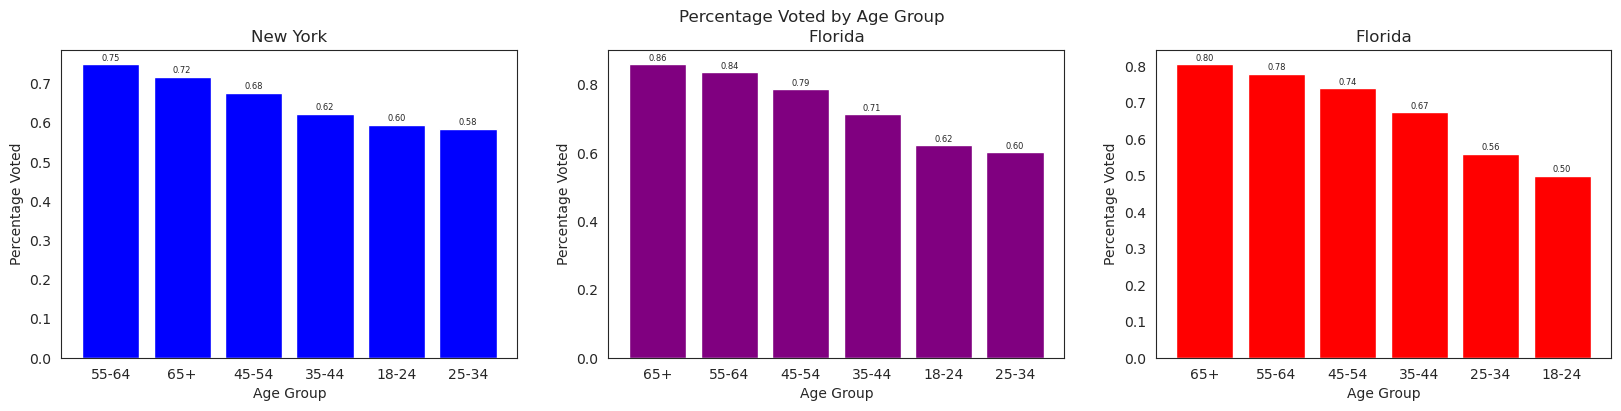

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(20,4))

NY_age = df_ny.groupBy('Age_Group').agg(count(when(col("General_2020")==True,True)).alias("Num_Voted"), count("General_2020").alias("Num_Total"))
NY_age = NY_age.withColumn("Age_Group", when(col("Age_Group").isNull(), "Unknown").otherwise(col("Age_Group")))
NY_age = NY_age.withColumn('Percent_Voted',col("Num_Voted")/col("Num_Total"))
NY_age = NY_age.orderBy('Percent_Voted', ascending=False)
NYage_pd = NY_age.toPandas()

axs[0].bar(NYage_pd.Age_Group,NYage_pd.Percent_Voted,color='blue')
axs[0].set_xlabel("Age Group")
axs[0].set_ylabel("Percentage Voted")
axs[0].set_title("New York")
for i, v in enumerate(NYage_pd.Percent_Voted):
    axs[0].text(i, v+0.01, '{:.2f}'.format(v), ha='center', fontsize=6)
    
FL_age = df_fl.groupBy('Age_Group').agg(count(when(col("General_2020")==True,True)).alias("Num_Voted"), count("General_2020").alias("Num_Total"))
FL_age = FL_age.withColumn("Age_Group", when(col("Age_Group").isNull(), "Unknown").otherwise(col("Age_Group")))
FL_age = FL_age.withColumn('Percent_Voted',col("Num_Voted")/col("Num_Total"))
FL_age = FL_age.orderBy('Percent_Voted', ascending=False)
FLage_pd = FL_age.toPandas()

axs[1].bar(FLage_pd.Age_Group,FLage_pd.Percent_Voted,color='purple')
axs[1].set_xlabel("Age Group")
axs[1].set_ylabel("Percentage Voted")
axs[1].set_title("Florida")
for i, v in enumerate(FLage_pd.Percent_Voted):
    axs[1].text(i, v+0.01, '{:.2f}'.format(v), ha='center', fontsize=6)

TX_age = df_tx.groupBy('Age_Group').agg(count(when(col("General_2020")==True,True)).alias("Num_Voted"), count("General_2020").alias("Num_Total"))
TX_age = TX_age.withColumn("Age_Group", when(col("Age_Group").isNull(), "Unknown").otherwise(col("Age_Group")))
TX_age = TX_age.withColumn('Percent_Voted',col("Num_Voted")/col("Num_Total"))
TX_age = TX_age.orderBy('Percent_Voted', ascending=False)
TXage_pd = TX_age.toPandas()

axs[2].bar(TXage_pd.Age_Group,TXage_pd.Percent_Voted,color='red')
axs[2].set_xlabel("Age Group")
axs[2].set_ylabel("Percentage Voted")
axs[2].set_title("Florida")
for i, v in enumerate(TXage_pd.Percent_Voted):
    axs[2].text(i, v+0.01, '{:.2f}'.format(v), ha='center', fontsize=6)

fig.suptitle('Percentage Voted by Age Group')
plt.show()

Age group also seems to impact whether someone voted or not, but not nearly as significantly. Older age groups tend to have slightly higher voting percentages than younger age groups across all three states.

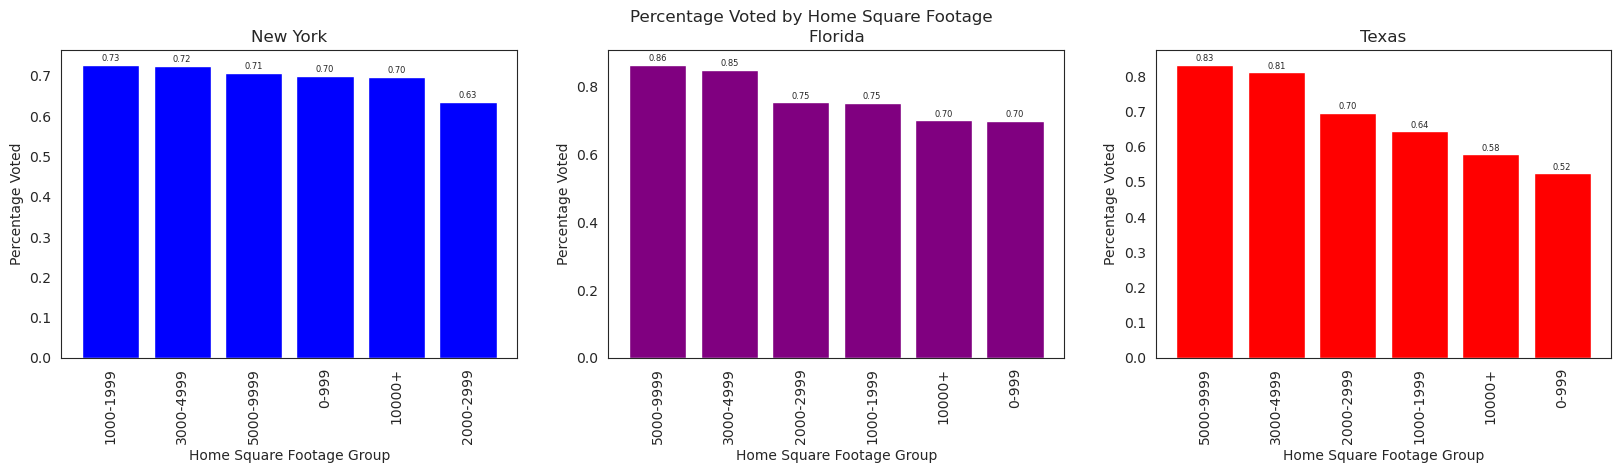

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(20,4))

NY_sqf = df_ny.groupBy('HomeSq_Footage_Group').agg(count(when(col("General_2020")==True,True)).alias("Num_Voted"), count("General_2020").alias("Num_Total"))
NY_sqf = NY_sqf.withColumn("HomeSq_Footage_Group", when(col("HomeSq_Footage_Group").isNull(), "Unknown").otherwise(col("HomeSq_Footage_Group")))
NY_sqf = NY_sqf.withColumn('Percent_Voted',col("Num_Voted")/col("Num_Total"))
NY_sqf = NY_sqf.orderBy('Percent_Voted', ascending=False)
NYsqf_pd = NY_sqf.toPandas()

axs[0].bar(NYsqf_pd.HomeSq_Footage_Group,NYsqf_pd.Percent_Voted,color='blue')
axs[0].set_xlabel("Home Square Footage Group")
axs[0].set_ylabel("Percentage Voted")
axs[0].set_title("New York")
for i, v in enumerate(NYsqf_pd.Percent_Voted):
    axs[0].text(i, v+0.01, '{:.2f}'.format(v), ha='center', fontsize=6)
    
FL_sqf = df_fl.groupBy('HomeSq_Footage_Group').agg(count(when(col("General_2020")==True,True)).alias("Num_Voted"), count("General_2020").alias("Num_Total"))
FL_sqf = FL_sqf.withColumn("HomeSq_Footage_Group", when(col("HomeSq_Footage_Group").isNull(), "Unknown").otherwise(col("HomeSq_Footage_Group")))
FL_sqf = FL_sqf.withColumn('Percent_Voted',col("Num_Voted")/col("Num_Total"))
FL_sqf = FL_sqf.orderBy('Percent_Voted', ascending=False)
FLsqf_pd = FL_sqf.toPandas()

axs[1].bar(FLsqf_pd.HomeSq_Footage_Group,FLsqf_pd.Percent_Voted,color='purple')
axs[1].set_xlabel("Home Square Footage Group")
axs[1].set_ylabel("Percentage Voted")
axs[1].set_title("Florida")
for i, v in enumerate(FLsqf_pd.Percent_Voted):
    axs[1].text(i, v+0.01, '{:.2f}'.format(v), ha='center', fontsize=6)

TX_sqf = df_tx.groupBy('HomeSq_Footage_Group').agg(count(when(col("General_2020")==True,True)).alias("Num_Voted"), count("General_2020").alias("Num_Total"))
TX_sqf = TX_sqf.withColumn("HomeSq_Footage_Group", when(col("HomeSq_Footage_Group").isNull(), "Unknown").otherwise(col("HomeSq_Footage_Group")))
TX_sqf = TX_sqf.withColumn('Percent_Voted',col("Num_Voted")/col("Num_Total"))
TX_sqf = TX_sqf.orderBy('Percent_Voted', ascending=False)
TXsqf_pd = TX_sqf.toPandas()

axs[2].bar(TXsqf_pd.HomeSq_Footage_Group,TXsqf_pd.Percent_Voted,color='red')
axs[2].set_xlabel("Home Square Footage Group")
axs[2].set_ylabel("Percentage Voted")
axs[2].set_title("Texas")
for i, v in enumerate(TXsqf_pd.Percent_Voted):
    axs[2].text(i, v+0.01, '{:.2f}'.format(v), ha='center', fontsize=6)

fig.suptitle('Percentage Voted by Home Square Footage')
for ax in axs:
    ax.tick_params(axis='x', labelrotation=90)
plt.show()

From the plots above, we see slight correlation between home square footage and percentage voted in Florida and Texas. On the other hand, we see almost no correlation between the two in New York.

# Model Fitting

We are conducting two different machine learning models, Logistic regression and a decision tree. From the two models, we aim to choose the best model, ( determined by a combination of precision, recall and AUC scores) and run individual models for each state in order to extract variable importance to examine variations among states with historically differing political affiliations.

In [26]:
#Set up the model
from pyspark.ml.feature import RFormula
supervised = RFormula(formula = 'General_2020 ~ Voters_Age + CommercialData_Education + Income + Home_Square_Footage + State')

Needed columns 
'Voters_Age', 'CommercialData_Education', 'CommercialData_EstimatedHHIncomeAmount',
'Residence_Addresses_Property_HomeSq_Footage',
'General_2020'

In [27]:
#Transform the dataframe
fittedRF = supervised.fit(df)

In [28]:
#Transform the dataframe
preparedDF = fittedRF.transform(df)

In [29]:
#Split the dataframe into training set and testing set
train, test = preparedDF.randomSplit([0.7,0.3], seed = 666)

In [30]:
#Construct a logictic regression model
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol = 'label', featuresCol = 'features')

In [31]:
#fit the model with training set
lrModel = lr.fit(train)

23/03/21 05:15:01 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/03/21 05:15:01 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [32]:
#Evaluate the model with the test set and calculate the AUC score
from pyspark.ml.evaluation import BinaryClassificationEvaluator
bi_evaluator = BinaryClassificationEvaluator()
lr_predictions = lrModel.transform(test)

auc = bi_evaluator.evaluate(lr_predictions, {bi_evaluator.metricName: "areaUnderROC"})
print("AUC = %g" % auc)

AUC = 0.694037


In [33]:
#Calculate the confusion metric
from pyspark.mllib.evaluation import MulticlassMetrics
lr_labels_and_preds = lr_predictions.select("label", "prediction").rdd
lr_metrics = MulticlassMetrics(lr_labels_and_preds)
print(lr_metrics.confusionMatrix().toArray())

[[ 656834.  565709.]
 [3069904. 8524497.]]


In [34]:
#Extract the precision and recal value of the confusion metric
print("Precision = %g" % lr_metrics.precision(1))
print("Recall = %g" % lr_metrics.recall(1))

Precision = 0.937767
Recall = 0.735225


In [35]:
#Calculate the accuracy score\
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
multi_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
lr_accuracy = multi_evaluator.evaluate(lr_predictions)
print('Accuracy:', lr_accuracy)

Accuracy: 0.7163432250308653


In [36]:
#Fit a decision tree model to the training set
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(labelCol='label', featuresCol = 'features')
dtModel = dt.fit(train)

In [ ]:
#Evaluate the performance of the decision tree model by the test set and calculate the AUC score
dt_predictions = dtModel.transform(test)
auc = bi_evaluator.evaluate(dt_predictions, {bi_evaluator.metricName: "areaUnderROC"})
print("AUC = %g" % auc)

AUC = 0.622633


In [ ]:
#Calculate the confusion metric
dt_labels_and_preds = dt_predictions.select("label", "prediction").rdd
dt_metrics = MulticlassMetrics(dt_labels_and_preds)
print(dt_metrics.confusionMatrix().toArray())

[[ 402002.  300492.]
 [3324736. 8789714.]]


In [ ]:
#Extract the precision and recall from the confusion metric
print("Precision = %g" % dt_metrics.precision(1))
print("Recall = %g" % dt_metrics.recall(1))


Precision = 0.966943
Recall = 0.725556


In [ ]:
#Calculate the accuracy
dt_accuracy = multi_evaluator.evaluate(dt_predictions)
print('Accuracy:', dt_accuracy)

Accuracy: 0.7171534805800821


In [ ]:

supervised2 = RFormula(formula = 'General_2020 ~ Voters_Age + CommercialData_Education + Income + Home_Square_Footage ')

In [ ]:
prepareDF_fl = supervised2.fit(df_fl).transform(df_fl)
lrModel_fl = lr.fit(prepareDF_fl)

In [ ]:
featureCols = pd.DataFrame(prepareDF_fl.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  prepareDF_fl.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')
featureCols.head()

,name
idx,
0,Voters_Age
1,CommercialData_Education_Unknown
2,CommercialData_Education_Some College - Likely
3,CommercialData_Education_Bach Degree - Extreme...
4,CommercialData_Education_HS Diploma - Extremel...


In [ ]:
#Extract coefficient
import numpy as np
import pandas as pd
coefsArray = np.array(lrModel_fl.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them
coefsDF.head()

,coefs,name
1,-0.377804,CommercialData_Education_Unknown
13,0.000005,Home_Square_Footage
12,0.000005,Income
0,0.022247,Voters_Age
9,0.086571,CommercialData_Education_Less than HS Diploma ...


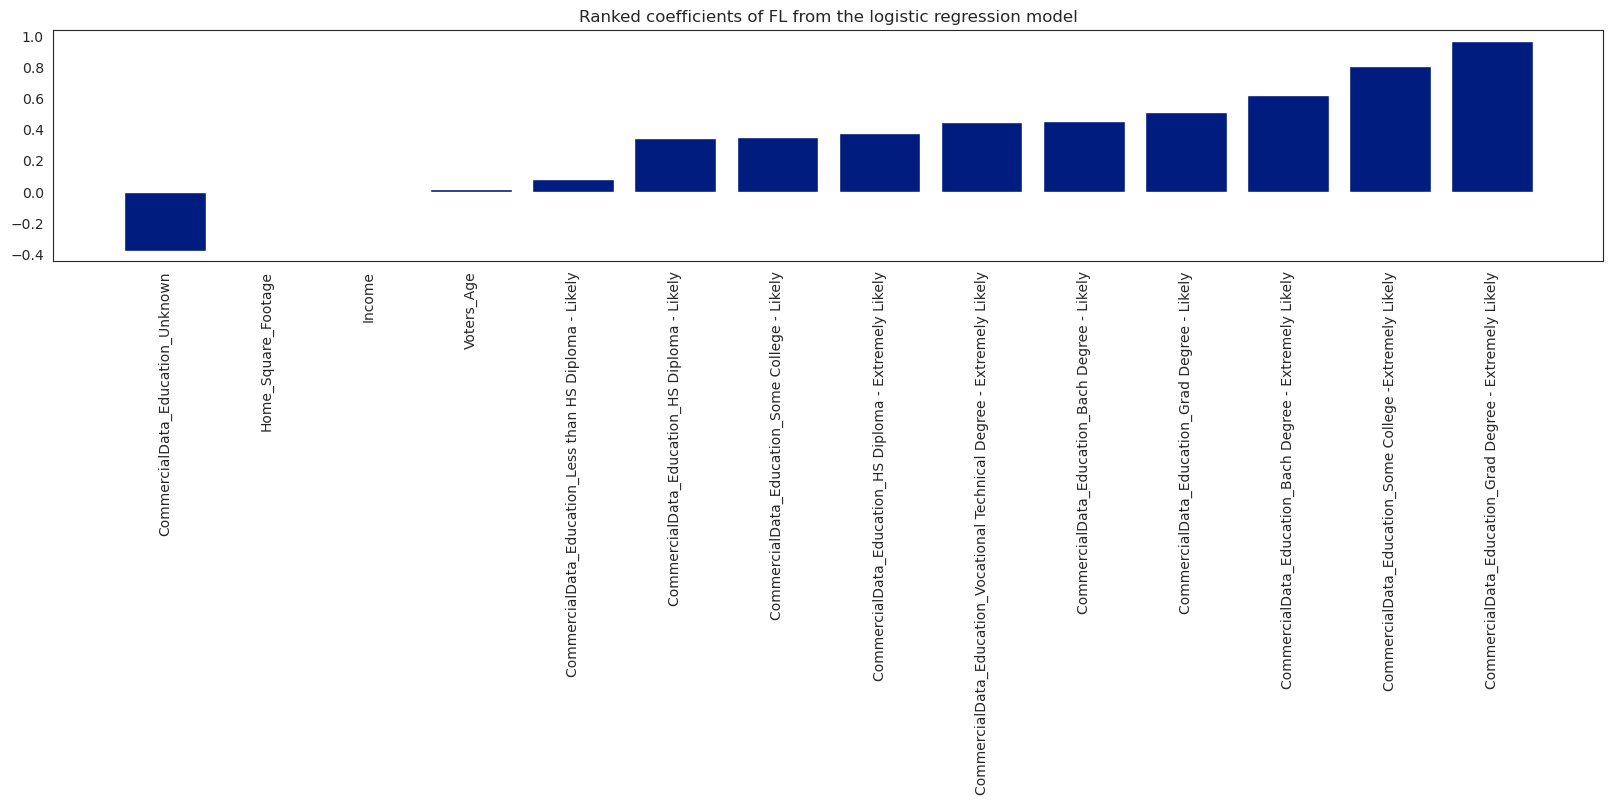

In [ ]:
#plot the coefficient
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,3)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF.coefs)
plt.title('Ranked coefficients of FL from the logistic regression model')
plt.show()

In [ ]:
prepareDF_ny = supervised2.fit(df_ny).transform(df_ny)
lrModel_ny = lr.fit(prepareDF_ny)

In [ ]:
featureCols = pd.DataFrame(prepareDF_ny.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  prepareDF_ny.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')
featureCols.head()

,name
idx,
0,Voters_Age
1,CommercialData_Education_Unknown
2,CommercialData_Education_Bach Degree - Extreme...
3,CommercialData_Education_HS Diploma - Extremel...
4,CommercialData_Education_Some College - Likely


In [ ]:
#Extract coefficient
coefsArray = np.array(lrModel_ny.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them
coefsDF.head()

,coefs,name
1,-5.186247e-01,CommercialData_Education_Unknown
13,3.829250e-07,Home_Square_Footage
12,3.449285e-06,Income
9,3.290649e-03,CommercialData_Education_Less than HS Diploma ...
0,5.330214e-03,Voters_Age


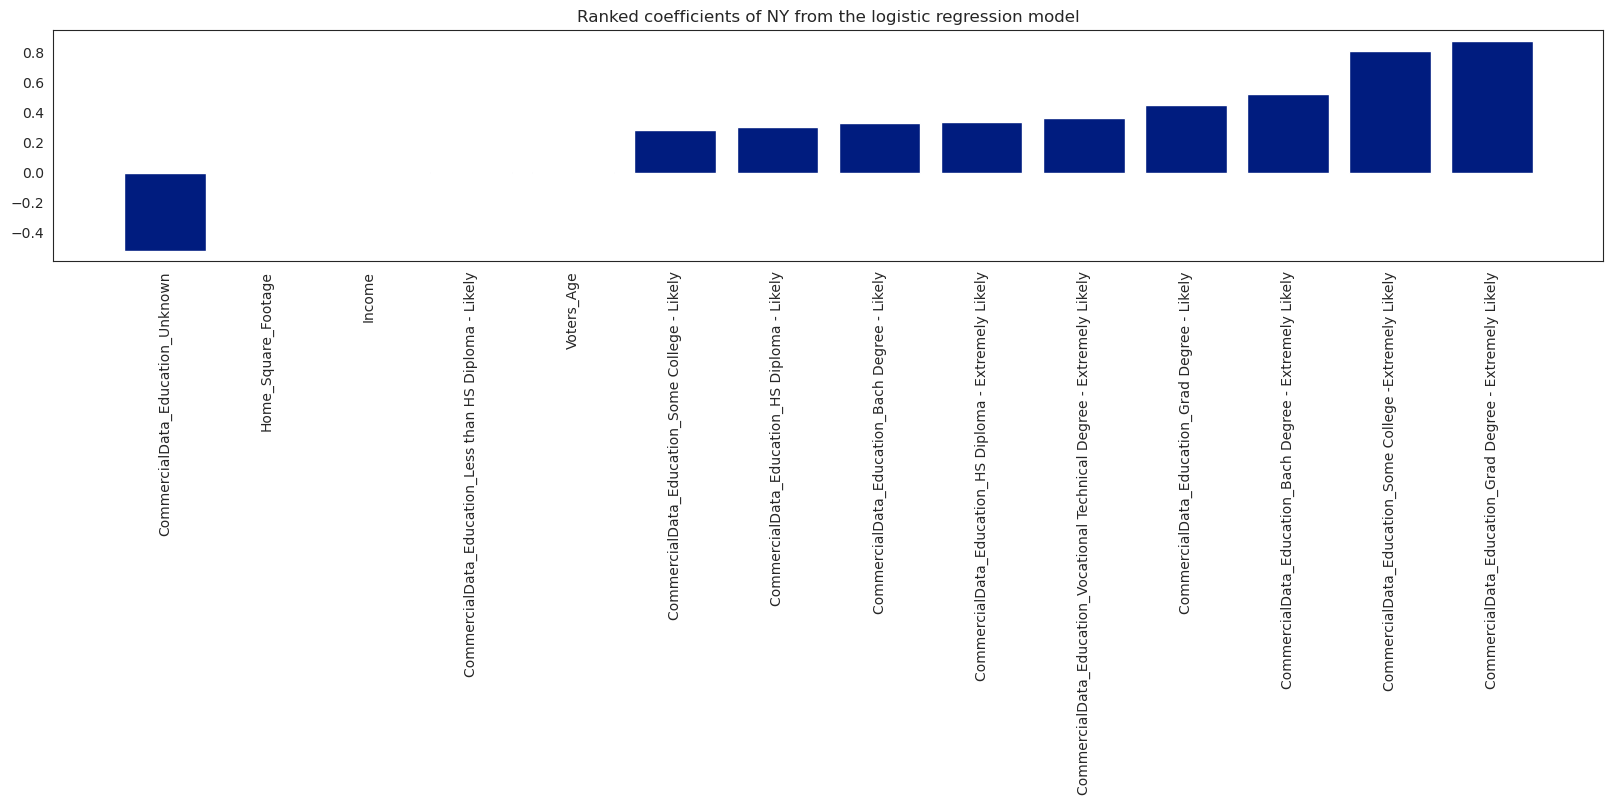

In [ ]:
#plot the coefficient
plt.rcParams["figure.figsize"] = (20,3)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF.coefs)
plt.title('Ranked coefficients of NY from the logistic regression model')
plt.show()

In [ ]:
prepareDF_tx = supervised2.fit(df_tx).transform(df_tx)
lrModel_tx = lr.fit(prepareDF_tx)

In [ ]:
featureCols = pd.DataFrame(prepareDF_tx.schema["features"].metadata["ml_attr"]["attrs"]["binary"]+
  prepareDF_tx.schema["features"].metadata["ml_attr"]["attrs"]["numeric"]).sort_values("idx")

featureCols = featureCols.set_index('idx')
featureCols.head()

,name
idx,
0,Voters_Age
1,CommercialData_Education_Unknown
2,CommercialData_Education_Some College - Likely
3,CommercialData_Education_Bach Degree - Extreme...
4,CommercialData_Education_HS Diploma - Likely


In [ ]:
#Extract coefficient
coefsArray = np.array(lrModel_tx.coefficients)  # convert to np.array
coefsDF = pd.DataFrame(coefsArray, columns=['coefs'])  # to pandas

coefsDF = coefsDF.merge(featureCols, left_index=True, right_index=True)  # join it with featureCols we created above
coefsDF.sort_values('coefs', inplace=True)  # Sort them
coefsDF.head()

,coefs,name
1,-0.197443,CommercialData_Education_Unknown
12,0.000006,Income
13,0.000009,Home_Square_Footage
0,0.021795,Voters_Age
9,0.051007,CommercialData_Education_Less than HS Diploma ...


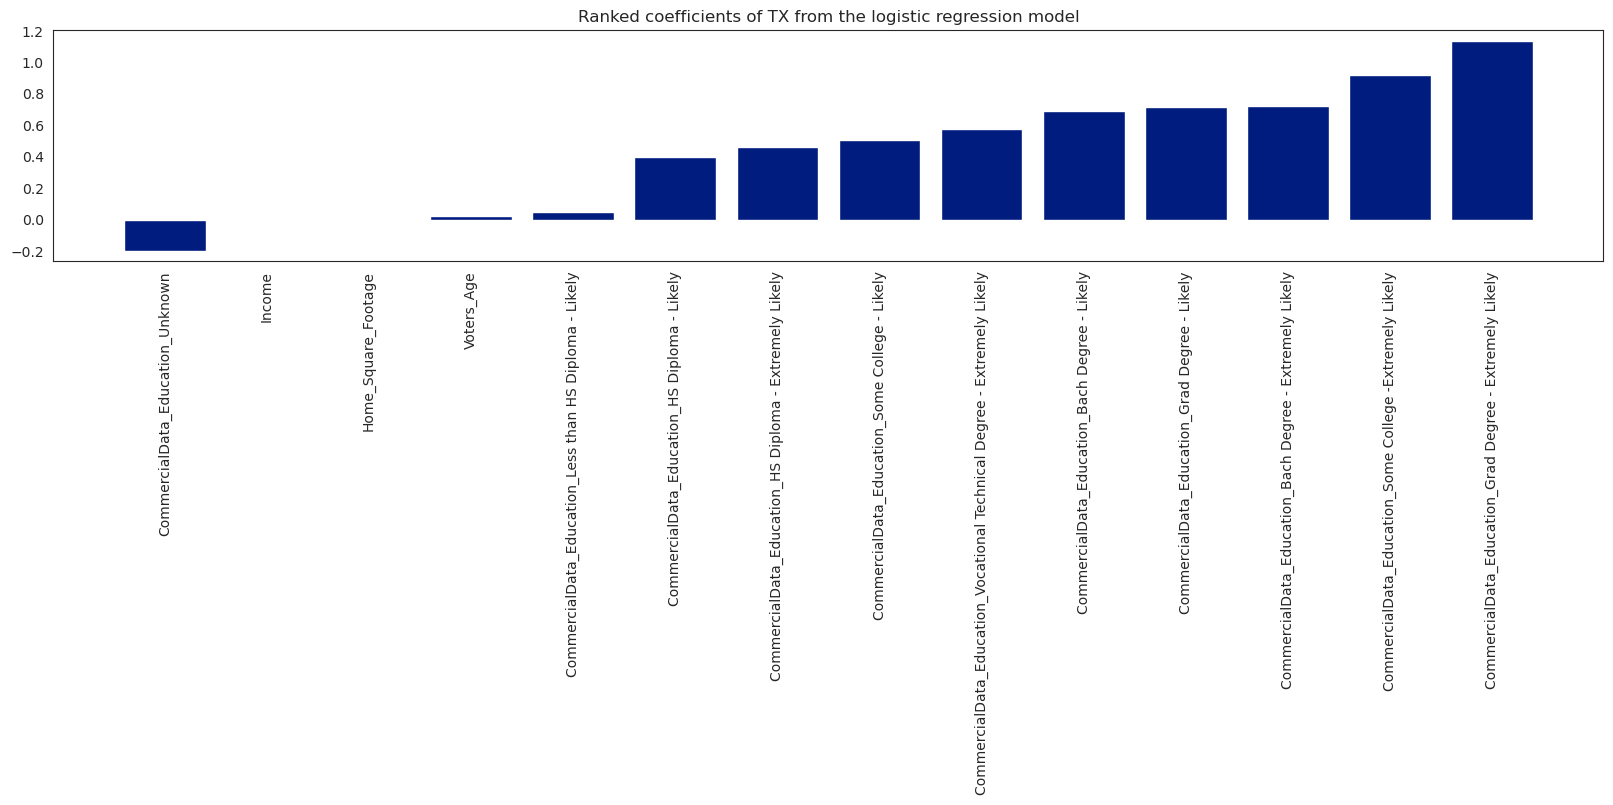

In [ ]:
#plot the coefficient
plt.rcParams["figure.figsize"] = (20,3)
plt.xticks(rotation=90)
plt.bar(coefsDF.name, coefsDF.coefs)
plt.title('Ranked coefficients of TX from the logistic regression model')
plt.show()

With a logistic regression model, we have a precision score of 0.93, recall score of 0.73 (suggesting low false positives and higher false negatives), and an AUC of 0.69. With a decision tree model, we have a precision and recall of 0.68 and an AUC of 0.62. We notice that our logistic regression model performs quite well. This could be because most of our chosen variables are numerical rather than categorical, and thus, a logistic regression approach is able to predict with greater accuracy. The precision scores and recall scores are both relatively high, which is quite good. In general, an accuracy score of 70% or greater is ideal. This suggests that our variables of income, education, home square footage, and age are exceptional predictors of our outcome, voter turnout.

# Conclusion

From our models, we can infer that these predictor variables indeed have a correlation and influence of an individual's ability or willingness to vote. This is inline with what we expected from our EDA. Our plots showed a large positive correlation for variables education and age in relation to the percentage of people who voted. However, we did find that home square footage did not seem to have a large or apparent pattern. Another variable we wished to examine was whether the historic political affiliation of a state would have an impact on the relevance/importance of our predictor variables. To accomplish this we ran the model that returned the greatest precision to each of our three states. We were not interested in the ability to predict, only what the algorithm determined each variable to be, and so we ran the model without splitting (into train and test datasets) in hopes that it would give us a more accurate variable importance as it had more data to work with. We found that across the three states the order of the variable importance generally stayed the same. This indicates that political affiliation does not seem to be a factor of importance. However, we can see that New York deviates from the other two in that the variable importance of 'Less Than HS Diploma' was significantly less, even lower than that of voter age. This means that in New York, not having a HS Diploma would greatly reduce your ability/likelihood to vote. This is not a good thing because it suggests that residents of New York who do not have a high school degree are extremely underrepresented (even in comparison to other states) as many of them are not showing up to the polls. In addition, Texas in particular seems to demonstrate a high variance between the coefficients representing education levels, demonstrating a left skewed distribution with higher education on the right. This means that in Texas in particular, the greater the level of education, the higher the likelihood of voting. This left skewed distribution is present in all states. However, in Texas, we see a steeper gradient, signaling a larger discrepancy. It is important to take note of the limitations of our report and models as a result of our available resources and the methodology we used to best optimize them; specifically the limiting factor of cost. In order to work within our limited budget we had to constrain our computational resources, which means using smaller than ideal clusters. Given the size of our clusters, it would be infeasible and unrealistic to work with the entire dataset (all the states) and so instead we chose three states to represent the entire country as well as the political states for Democratic, Republican and Neutral (NY - Democratic, Texas - Republican, FL - Neutral). Even with these subsets, each operation took a large amount of time which limited what we were able to try. Obviously, drawing conclusions from our limited sampling of just three states about the country and political affiliation is suboptimal. As such, an improvement that could be done is conducting the same procedure on a larger dataset with more representative states for each political affiliation. Another potential improvement could be considering the interactions between each of the predictor variables, as although our EDA revealed many of the variables did not seem to be correlated with one another, the interactions could still yield a minor but measurable improvement on our metrics. Overall, through our analysis we were able to conclude that voter age, income, home square footage, and education have a strong relationship with voter turnout, with education being the strongest predictor.

One thing that was demonstrated to us through this report is the difficulties of big data. This includes, but is not limited to, the sheer volume of data we had to work with. For example, in much of our code above we had to break portions down into smaller chunks to help manage how much the cluster was doing to prevent kernel crashes, and for some of our visualizations we used random sampling in order to avoid timeouts brought about by the some 40 million rows of observations that were being plotted. Another related difficulty is the storage and handling of big data through GCS. Although GCS was quite intuitive in its usage, the process of storing and accessing was still a learning curve, as in previous classes we had only stored and worked with data from our local machines. When working with big data, each action has larger reactions and ramifications. The main challenge is to break the data down into digestible, useful, generalized information, while at the same time maintaining the power afforded by such vast amounts of data.  